In [ ]:
# import comet_ml at the top of your file
from comet_ml import Experiment

In [ ]:
# Create an experiment with your api key
experiment = Experiment(
    api_key="HfSNpkY9koDD8GCccjV6a7o3K",
    project_name="nlp-tweet-sentiment-analysis",
    workspace="mafikengz",
)

In [ ]:
import re
import string

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', 100)
plt.style.use('fivethirtyeight')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score , classification_report
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import tweepy
from textblob import TextBlob
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

In [ ]:
df_train = pd.read_csv('input/train.csv' , encoding='UTF-8')
df_test = pd.read_csv('input/test_with_no_labels.csv' , encoding='ISO-8859-1')

In [ ]:
tweets = df_train.meassage
for i in range(50):
    print(tweets)

In [ ]:
df_test.head()

In [29]:
print('Dataset size:',df_train.shape)
print('Columns are:',df_train.columns)

Dataset size: (15819, 10)
Columns are: Index(['sentiment', 'message', 'tweetid', 'Clean_tweets', 'Tweet_tokenized',
       'Tweet_nonstop', 'Tweet_stemmed', 'Tweet_lemmatized', 'Subjectivity',
       'Polarity'],
      dtype='object')


In [ ]:
df_train.info()


In [ ]:
sns.countplot(x = 'sentiment', data = df_train)

(-0.5, 399.5, 199.5, -0.5)

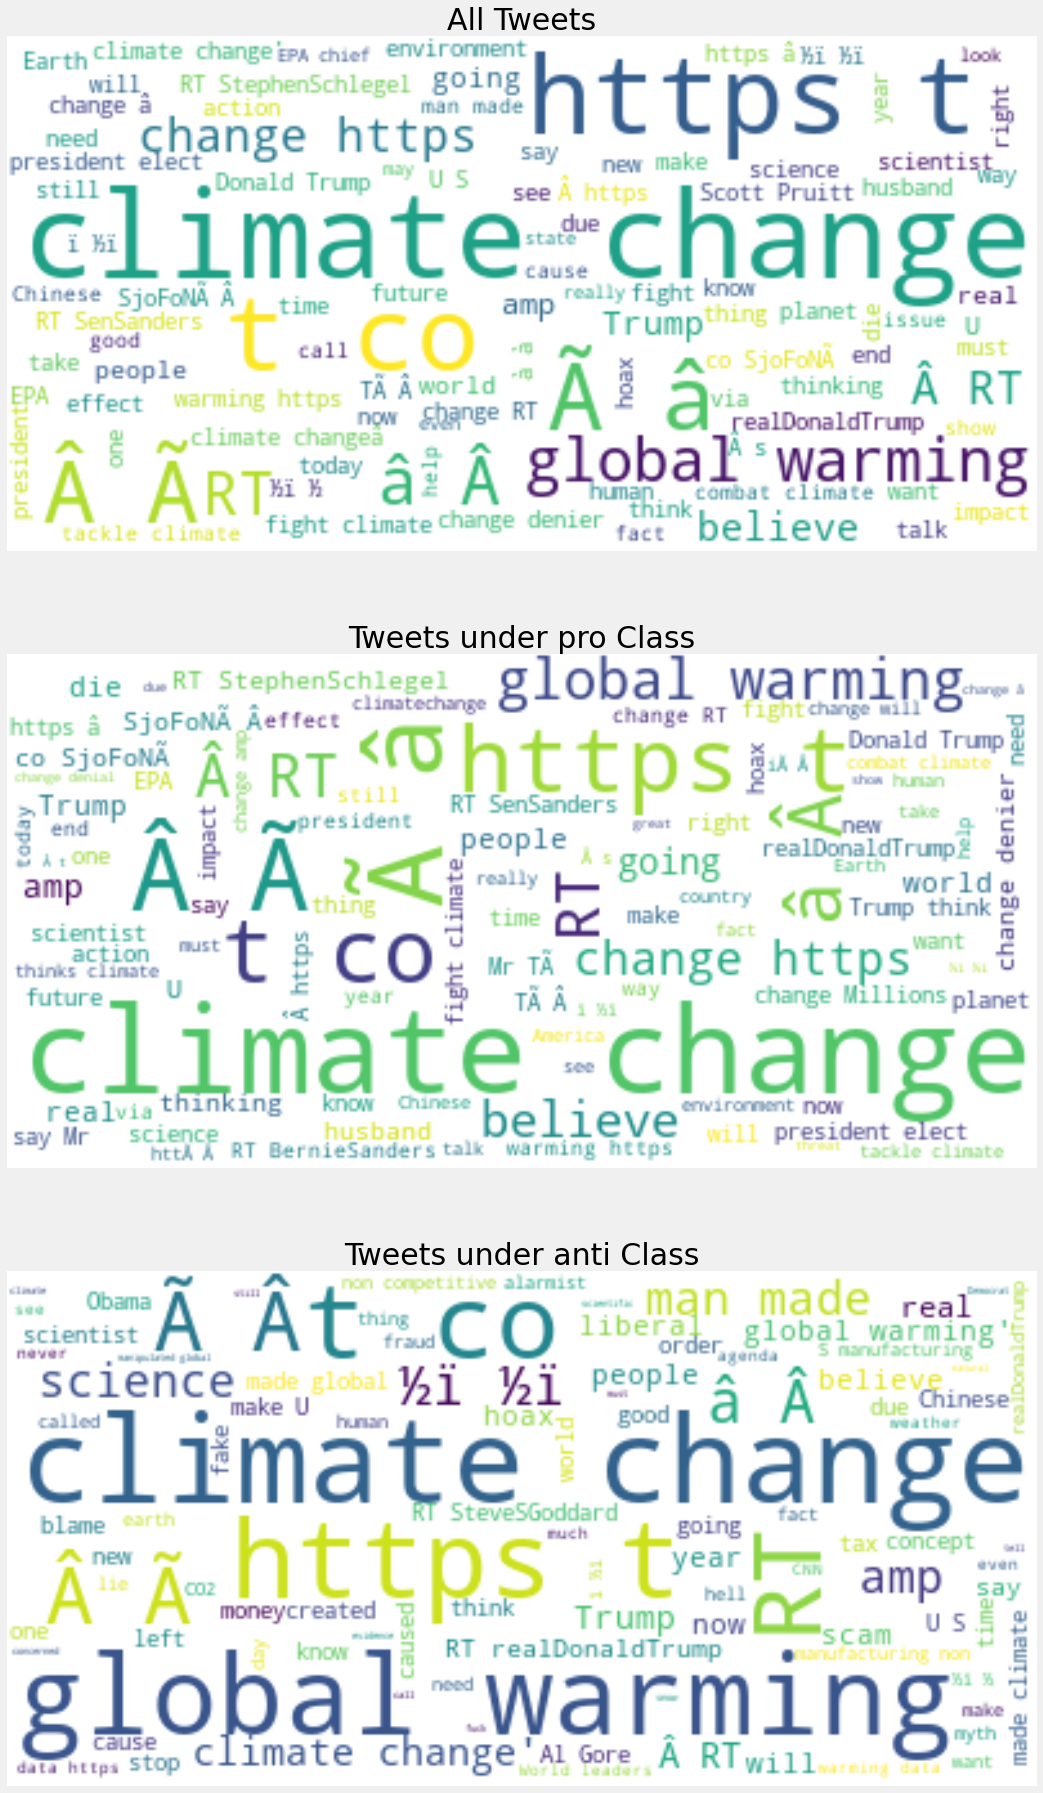

In [28]:
from wordcloud import WordCloud, STOPWORDS , ImageColorGenerator

# Start with one review:
df_pro = df_train[df_train['sentiment']==1]
df_neutral = df_train[df_train['sentiment']==0]
df_news = df_train[df_train['sentiment']==2]
df_anti = df_train[df_train['sentiment']==-1]


tweet_All = " ".join(review for review in df_train.message)
tweet_pro = " ".join(review for review in df_pro.message)
tweet_neutral = " ".join(review for review in df_neutral.message)
tweet_news = " ".join(review for review in df_news.message)
tweet_anti = " ".join(review for review in df_anti.message)

fig, ax = plt.subplots(3, 1, figsize  = (30,30))

# Create and generate a word cloud image:
wordcloud_ALL = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(tweet_All)
wordcloud_pro = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(tweet_pro)
wordcloud_neutral = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(tweet_neutral)
wordcloud_news = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(tweet_news)
wordcloud_anti = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(tweet_anti)

# Display the generated image:
ax[0].imshow(wordcloud_ALL, interpolation='bilinear')
ax[0].set_title('All Tweets', fontsize=30)
ax[0].axis('off')
ax[1].imshow(wordcloud_pro, interpolation='bilinear')
ax[1].set_title('Tweets under pro Class',fontsize=30)
ax[1].axis('off')
ax[2].imshow(wordcloud_neutral, interpolation='bilinear')
ax[2].set_title('Tweets under Neutral - ADR Class',fontsize=30)
ax[2].axis('off')
ax[2].imshow(wordcloud_news, interpolation='bilinear')
ax[2].set_title('Tweets under news Class',fontsize=30)
ax[2].axis('off')
ax[2].imshow(wordcloud_anti, interpolation='bilinear')
ax[2].set_title('Tweets under anti Class',fontsize=30)
ax[2].axis('off')

#### Quick Notes:

- Few high frequency tokens such as 'Climate change', 'Glabal warming', 'URL links' are frequently used in all the categorical classes

- Removing these words along with stops words would not impact the performance.

### 2. Data Preprocessing

Most of the text data are cleaned by following below steps.

- **Remove punctuations**
- **URL links**
- **Tokenization:** Converting a sentence into list of words
- **Remove stopwords**
- **Lammetization/stemming:** Tranforming any form of a word to its root word

In [27]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [30]:
#Remove Noise
def _remove_noise(data):
    '''
    Function remove noise from the dataset
    Args:
        data: pandas dataframe
    return:
        Clean standard formated data
    '''

    data = re.sub('RT' , '' , data) #Remove RT with Retweet
    data = re.sub('#[A-Za-z0-9]+' , '' , data) # Remove any string with a #
    data = re.sub('#' , '' , data) # Remove any string with a #
    data = re.sub('\\n' , '' , data) #Remove any new lines
    data = re.sub(r'http\S+', '', data)#Remove Hyperlinks
    data  = "".join([char for char in data if char not in string.punctuation]) #Remove punctuations
    data = re.sub(r'[^\x00-\x7f]',r'', data)
#     data = re.sub('[0-9]+', '', data)
    return data

In [31]:
#Clean the data
df_train['Clean_tweets'] = df_train.message.apply(_remove_noise).str.strip()
df_test['Clean_tweets'] = df_test.message.apply(_remove_noise).str.strip()

In [32]:
#Tokenization
def tokenization(data):
    data = re.split('\W+', data)
    return data

df_train['Tweet_tokenized'] = df_train.Clean_tweets.apply(lambda x: tokenization(x.lower()))
df_train.head(20)

,sentiment,message,tweetid,Clean_tweets,Tweet_tokenized,Tweet_nonstop,Tweet_stemmed,Tweet_lemmatized,Subjectivity,Polarity
0,1,"PolySciMajor EPA chief doesn't think carbon dioxide is main cause of global warming and.. wait, ...",625221,PolySciMajor EPA chief doesnt think carbon dioxide is main cause of global warming and wait what...,"[polyscimajor, epa, chief, doesnt, think, carbon, dioxide, is, main, cause, of, global, warming,...","[polyscimajor, epa, chief, doesnt, think, carbon, dioxide, main, cause, global, warming, wait, v...","[polyscimajor, epa, chief, doesnt, think, carbon, dioxid, main, caus, global, warm, wait, via, m...","[polyscimajor, epa, chief, doesnt, think, carbon, dioxide, main, cause, global, warming, wait, v...",0.166667,0.083333
1,1,It's not like we lack evidence of anthropogenic global warming,126103,Its not like we lack evidence of anthropogenic global warming,"[its, not, like, we, lack, evidence, of, anthropogenic, global, warming]","[like, lack, evidence, anthropogenic, global, warming]","[like, lack, evid, anthropogen, global, warm]","[like, lack, evidence, anthropogenic, global, warming]",0.000000,0.000000
2,2,RT @RawStory: Researchers say we have three years to act on climate change before itâs too lat...,698562,RawStory Researchers say we have three years to act on climate change before its too late,"[rawstory, researchers, say, we, have, three, years, to, act, on, climate, change, before, its, ...","[rawstory, researchers, say, three, years, act, climate, change, late]","[rawstori, research, say, three, year, act, climat, chang, late]","[rawstory, researcher, say, three, year, act, climate, change, late]",0.600000,-0.300000
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year in the war on climate change https://t.co/44wOTxTLcD,573736,WIRED 2016 was a pivotal year in the war on climate change,"[wired, 2016, was, a, pivotal, year, in, the, war, on, climate, change]","[wired, 2016, pivotal, year, war, climate, change]","[wire, 2016, pivot, year, war, climat, chang]","[wired, 2016, pivotal, year, war, climate, change]",0.800000,0.500000
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, sexist, climate change denying bigot is leading in...",466954,SoyNovioDeTodas Its 2016 and a racist sexist climate change denying bigot is leading in the polls,"[soynoviodetodas, its, 2016, and, a, racist, sexist, climate, change, denying, bigot, is, leadin...","[soynoviodetodas, 2016, racist, sexist, climate, change, denying, bigot, leading, polls]","[soynoviodetoda, 2016, racist, sexist, climat, chang, deni, bigot, lead, poll]","[soynoviodetodas, 2016, racist, sexist, climate, change, denying, bigot, leading, poll]",0.000000,0.000000
5,1,Worth a read whether you do or don't believe in climate change https://t.co/ggLZVNYjun https://t...,425577,Worth a read whether you do or dont believe in climate change,"[worth, a, read, whether, you, do, or, dont, believe, in, climate, change]","[worth, read, whether, dont, believe, climate, change]","[worth, read, whether, dont, believ, climat, chang]","[worth, read, whether, dont, believe, climate, change]",0.100000,0.300000
6,1,RT @thenation: Mike Pence doesnât believe in global warming or that smoking causes lung cancer...,294933,thenation Mike Pence doesnt believe in global warming or that smoking causes lung cancer,"[thenation, mike, pence, doesnt, believe, in, global, warming, or, that, smoking, causes, lung, ...","[thenation, mike, pence, doesnt, believe, global, warming, smoking, causes, lung, cancer]","[thenat, mike, penc, doesnt, believ, global, warm, smoke, caus, lung, cancer]","[thenation, mike, penny, doesnt, believe, global, warming, smoking, cause, lung, cancer]",0.000000,0.000000
7,1,"RT @makeandmendlife: Six big things we can ALL do today to fight climate change, or how to be a ...",992717,makeandmendlife Six big things we can ALL do today to fight climate change or how to be a climat...,"[makeandmendlife, six, big, things, we, can, all, do, today, to, fight, 

In [ ]:
#Remove Stopwords
stopword = nltk.corpus.stopwords.words('english')
def remove_stopwords(data):
    data = [word for word in data if word not in stopword]
    return data
    
df_train['Tweet_nonstop'] = df_train['Tweet_tokenized'].apply(lambda x: remove_stopwords(x))
df_train.head(10)

In [ ]:
#Stemming
stemmer = nltk.PorterStemmer()
def stemming(data):
    data = [stemmer.stem(word) for word in data]
    return data

df_train['Tweet_stemmed'] = df_train['Tweet_nonstop'].apply(lambda x: stemming(x))
df_train.head()

In [ ]:
#Lemmitization
lem = nltk.WordNetLemmatizer()

def lemmatizer(data):
    data = [lem.lemmatize(word) for word in data]
    return data

df_train['Tweet_lemmatized'] = df_train['Tweet_nonstop'].apply(lambda x: lemmatizer(x))
df_train.head()

In [ ]:
def clean_text(data):
    text_lc = "".join([word.lower() for word in data if word not in string.punctuation]) # remove puntuation
    text_rc = re.sub('[0-9]+', '', text_lc)
    tokens = re.split('\W+', text_rc)    # tokenization
    data = [stemmer.stem(word) for word in tokens if word not in stopword]  # remove stopwords and stemming
    return data

In [ ]:
countVectorizer = CountVectorizer(analyzer=clean_text)
data = df_train['message'].apply(_remove_noise)
countVector = countVectorizer.fit_transform(data)
print('{} Number of tweets has {} words'.format(countVector.shape[0], countVector.shape[1]))
print(countVectorizer.get_feature_names())

In [ ]:
count_vect_df = pd.DataFrame(countVector.toarray(), columns=countVectorizer.get_feature_names())
count_vect_df.head()

In [ ]:
df_train.Clean_tweets[7]

In [ ]:
df_train.message[7]

In [35]:
#Get subjectivity and polarity
def _get_subjectivity(data):
    """
    Function returns a subjectivity score: ranges between 0-1
    score 0:objective-refers to factual information
    score 1:subjevtive-refer to personal opinion, emotion or judgment
    Args:
        data: pandas dataframe
    Returns:
        Score:(float) range(0,1)
    """
    return TextBlob(data).sentiment.subjectivity

def _get_polarity(data):
    """
    Function returns polarity score: ranges between [-1,1]
    Score -1: negative statement
    Score 1: positive statement
    
    Args:
        data: pandas dataframe
    Returns:
        Score:float range(-1,1)
    """
    return TextBlob(data).sentiment.polarity


In [36]:
df_train['Subjectivity'] = df_train['Clean_tweets'].apply(_get_subjectivity)
df_train['Polarity'] = df_train['Clean_tweets'].apply(_get_polarity)

In [ ]:
df_train.head()

In [ ]:
#Sentiment Intensity Analyser
def _get_SIA(data):
    """
    Function returns a sentiment score 
    relies on a dictionary that maps lexical features to emotion intensities
    sentiment scores: obtained by summing up the intensity of each word in the text
    
    Args
    """
    sia = SentimentIntensityAnalyzer()
    sentiment = sia.polarity_scores(data)
    return sentiment

In [ ]:
compound = []
fact = []
pos = []
neu = []
neg = []
SIA = 0

In [ ]:
for i in range(0 , len(df_train['Clean_tweets'])):
    SIA = _get_SIA(df_train['Clean_tweets'][i])
    compound.append(SIA['compound'])
#     fact.append(SIA['fact'])
    pos.append(SIA['pos'])
    neu.append(SIA['neu'])
    neg.append(SIA['neg'])

In [ ]:
#Merge the sentiment scores
df_train['Compound'] = compound
df_train['Neutral'] = neu
df_train['Positive'] = pos
df_train['Negative'] = neg

In [37]:
def _get_sentiment(score):
    if score == -1:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    elif score == 1:
        return 'Positive'
    elif score == 2:
        return 'Factual'

In [43]:
sens = df_train['sentiment'].apply(_get_sentiment)

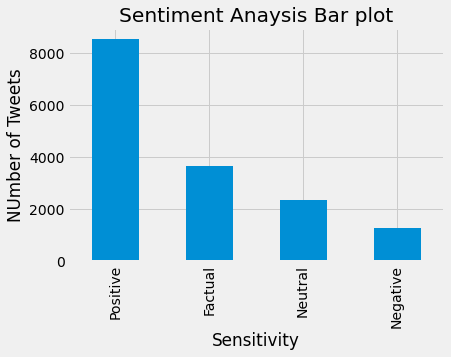

In [42]:
#Create Bar plot
sens.value_counts().plot(kind='bar')
plt.title('Sentiment Anaysis Bar plot')
plt.xlabel('Sensitivity')
plt.ylabel('NUmber of Tweets')
plt.show()

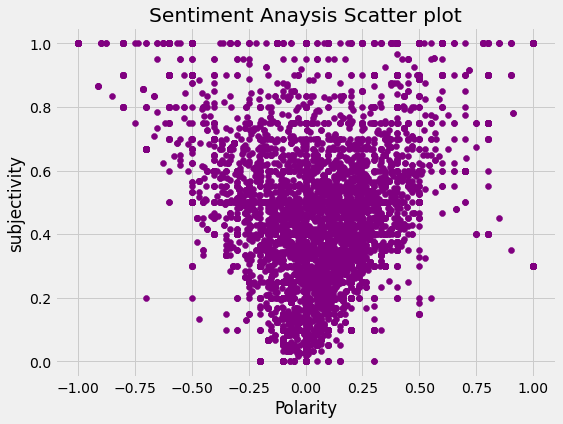

In [44]:
#Create scatter plot to showcase the subjectivity and polarity
plt.figure(figsize=(8,6))
for i in range(0, df_train.shape[0]):
    plt.scatter(df_train['Polarity'][i] , df_train['Subjectivity'][i], color='Purple')
plt.title('Sentiment Anaysis Scatter plot')
plt.xlabel('Polarity')
plt.ylabel('subjectivity')
plt.show()